# Takens Embeddings

In this notebook, we'll explore the Takens embeddings introduced in lecture for applying TDA methods to time series data.

We'll use tge package `giotto-tda` which has a Takens embedding module with a lot of nice features.

In [37]:
# Import the gtda modules
from gtda.time_series import SingleTakensEmbedding
from gtda.homology import VietorisRipsPersistence
from gtda.diagrams import Scaler, Filtering, PersistenceEntropy, BettiCurve, PairwiseDistance
from gtda.graphs import KNeighborsGraph, GraphGeodesicDistance
from gtda.pipeline import Pipeline

import numpy as np
from sklearn.metrics import pairwise_distances

import plotly.express as px
from plotly.offline import init_notebook_mode, iplot
init_notebook_mode(connected=True)

# gtda plotting functions
from gtda.plotting import plot_heatmap

# Import data from openml
import openml
from openml.datasets.functions import get_dataset

# Plotting functions
from gtda.plotting import plot_diagram, plot_betti_surfaces
from gtda.plotting import plot_point_cloud

# MatPLotLib
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

## A Simple Example

We'll start with a simple signal consisting of a noisy sine curve.

In [38]:
n_samples = 1000
domain = np.linspace(0,2*np.pi,n_samples)
noise_level = 0.5
frequency = 4

signal = np.array([np.sin(frequency*x) + noise_level * np.random.random() for x in domain])

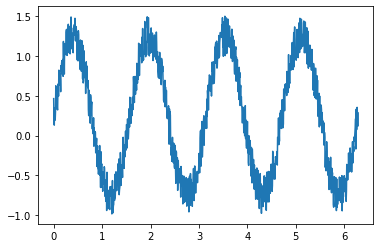

In [39]:
plt.plot(domain,signal)
plt.show()

The *sliding window embedding* of the signal $f:[0,2\pi] \to \mathbb{R}$ is defined in terms of two parameters:
- $\tau$ is the *delay*
- $d$ is the *embedding dimension*

The sliding window embedding is given by
\begin{align}
\mathrm{SW}_{d,\tau}f:[0,2\pi] &\to \mathbb{R}^d \\
t &\mapsto \mathrm{SW}_{d,\tau}f(t) = (f(t),f(t + \tau),f(t+2\tau),\ldots,f(t+(d-1)\tau))
\end{align}

Let's start by embedding in $\mathbb{R}^3$ (i.e. $d = 3$). We can experiment with different delays.

In [40]:
dimension = 3
time_delay = 10

embedder = SingleTakensEmbedding(parameters_type='fixed',dimension=dimension,time_delay=time_delay)
embedded_signal = embedder.fit_transform(signal)

Let's take a look at the shape of the result.

In [41]:
print('Shape of embedded point cloud:', embedded_signal.shape)

Shape of embedded point cloud: (980, 3)


Notice that the number of points in the point cloud is `n_samples`-$(d-1)\tau$. This is to mitigate boundary effects on the sliding window.

Since we embedded in $\mathbb{R}^3$, we can take a look at the embedded point cloud.

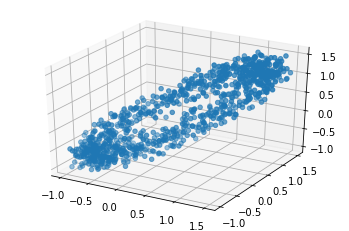

In [42]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

xs = embedded_signal[:,0]
ys = embedded_signal[:,1]
zs = embedded_signal[:,2]

ax.scatter(xs, ys, zs)
plt.show()

It looks like a noisy ellipse, which agrees with our computation in lecture. `giotto` has some useful plotting tools which allow us to manipulate the plot to get a better view.

In [43]:
plot_point_cloud(embedded_signal)

We did a computation in class which showed that the embedded point cloud is at its 'roundest' when $\omega \cdot d \cdot \tau = 0 \, (\mathrm{mod} \, \pi)$, where $\omega$ is the frequency. Since we are embedding with $d = 3$, we should get a round circle when $\tau = \frac{\pi}{3\omega}$. Let's test this out.

**Note:** Since we are working with a discrete approximation of the signal, $\tau$ is input as an integer---i.e., it's the number of indices to skip in the vector of signal sample values. This means we need to do a coordinate transformation and use the following time delay
$$
\hat{\tau} = \tau \cdot \frac{\mathrm{n}}{2\pi} = \frac{\pi}{3\omega} \cdot \frac{\mathrm{n}}{2\pi} = \frac{\mathrm{n}}{6 \omega},
$$
where $n = $`n_samples`.

In [44]:
time_delay = int(n_samples/(6*frequency))

embedder = SingleTakensEmbedding(parameters_type='fixed',dimension=dimension,time_delay=time_delay)
embedded_signal = embedder.fit_transform(signal)

plot_point_cloud(embedded_signal)

Trying this for different values of $\tau$, we see that the value above does seem to be of 'optimal roundness'.

In [45]:
tau = np.pi/5 # tau is a number between 0 and 2pi

time_delay = int(tau*n_samples/(2*np.pi)) # coordinate transformation to discrete steps

embedder = SingleTakensEmbedding(parameters_type='fixed',dimension=dimension,time_delay=time_delay)
embedded_signal = embedder.fit_transform(signal)

plot_point_cloud(embedded_signal)

Let's switch back to $\tau = \frac{\pi}{3\omega}$. 

Next we observe that this circle is actually 'multiply covered'. I.e., since the signal runs through $\omega$ full periods, the circle is run over $\omega$ times.

To see this, we can plot subsets of the embedded point cloud.

In [46]:
tau = np.pi/(3*frequency) 
time_delay = int(tau*n_samples/(2*np.pi))

embedder = SingleTakensEmbedding(parameters_type='fixed',dimension=dimension,time_delay=time_delay)
embedded_signal = embedder.fit_transform(signal)

plot_start = 0*int(1000/frequency)
plot_end = 1*int(1000/frequency)

truncated_embedded_signal = embedded_signal[plot_start:plot_end,:]
plot_point_cloud(truncated_embedded_signal)

Projecting the point cloud to one of the coordinate axes produces a 1-dimensional signal which looks like what we started with, up to a translation.

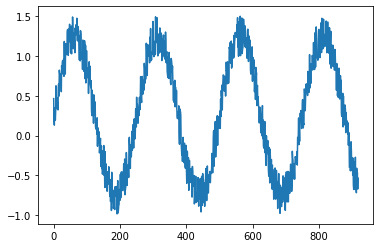

In [47]:
projection_coord = 0
projected_signal = embedded_signal[:,projection_coord]
plt.plot(projected_signal)
plt.show()

Recalling Takens' Theorem: the 'philosophical idea' here is that the embedded circle represents a bunch of steps in some dynamical system, which lie along an attractor. The projected 1-dimensional signal represents the output of some observation function. The sliding window embedding then reconstructs the attractor! The reconstruction is only up to topology---observe that for different choices of $\tau$, we get different geometries, but the same topology.

Computing the PH of the embedded point cloud, we see that it has the (noisy) homology of a circle. The following is the syntax used for persistent homology in the `giotto` library.

In [48]:
homology_dimensions = [1]
VR = VietorisRipsPersistence(
    metric='euclidean', max_edge_length=100, homology_dimensions=homology_dimensions)

X_diagrams = VR.fit_transform(embedded_signal[None, :, :])

In [49]:
plot_diagram(X_diagrams[0])

As expected, the 'distinctness' of the degree-1 feature depends a lot on the parameters for the Takens embedding. We can see this by running over a few choices of $\tau$.

In [50]:
taus = [np.pi/(10*frequency),np.pi/(5*frequency),np.pi/(3*frequency),np.pi/(2*frequency)]

for tau in taus: 
    time_delay = int(tau*n_samples/(2*np.pi))

    embedder = SingleTakensEmbedding(parameters_type='fixed',dimension=dimension,time_delay=time_delay)
    embedded_signal = embedder.fit_transform(signal)
    
    X_diagrams = VR.fit_transform(embedded_signal[None, :, :])
    plot_diagram(X_diagrams[0])
    plt.show()

This should lead you to ask: given a signal with unknown 'ground truth' topology, how do we choose the correct $\tau$? Furthermore, how do we choose the correct embedding dimension $d$?

To my knowledge, this is still an open theoretical question in the TDA literature. The `giotto` package does have some statistical heuristics to choose 'optimal' parameters. To use this functionality, the user initializes with upper bounds on $d$ and $\tau$, and some existing algorithms for phase space reconstruction are used to adjust them.

**Note:** The initial upper bounds must satisfy $n \geq (d-1)*\tau$, where $n$ is the number of samples and $\tau$ is the discrete time delay.

**Heuristic:** Since the initializations give upper bounds, choosing them high (but satisfying the inequality above) seems to work best. However, choosing high upper bounds also increases compute time, so there is a trade off here.

In [51]:
dimension = 30
time_delay = 30

embedder = SingleTakensEmbedding(parameters_type='search',dimension=dimension,time_delay=time_delay)
embedded_signal = embedder.fit_transform(signal)

print('Optimal embedding time delay based on mutual information:', embedder.time_delay_)
print('Optimal embedding dimension based on false nearest neighbors:',embedder.dimension_)
print('Shape of embedded point cloud:', embedded_signal.shape)

Optimal embedding time delay based on mutual information: 25
Optimal embedding dimension based on false nearest neighbors: 8
Shape of embedded point cloud: (825, 8)


In [52]:
homology_dimensions = [1]
VR = VietorisRipsPersistence(
    metric='euclidean', max_edge_length=100, homology_dimensions=homology_dimensions)

X_diagrams = VR.fit_transform(embedded_signal[None, :, :])
plot_diagram(X_diagrams[0])

Let's compare the learned parameters to the optimal ones. We first convert the discrete time delay to the continuous one:

In [53]:
d = embedder.dimension_
tau = embedder.time_delay_

tau_continuous = tau*np.pi/n_samples

We then compute the quantity $\omega \cdot \tau \cdot d$ and divide by $\pi$. If the parameters are optimal, then the result should be an integer.

In [55]:
frequency*tau_continuous*d/np.pi

0.8

**(Unofficial) Homework:** Run this experiment many times, using different frequencies and record the values that you get for $\omega \cdot \tau \cdot d$. Does the opimization algorithm tend to produce $d$ and $\tau$ which make this product close to a multiple of $\pi$? If the answer is "Yes", that's great! If the answer is "No", maybe there is some room for improvement in this optimization algorithm...

## Lorenz Attractor

We motivated Takens' Theorem with the Lorenz system. Let's take a closer look at this using the `giotto` package. We can load in a point cloud version of the attractor as a preprocessed dataset.

In [17]:
point_cloud = get_dataset(42182).get_data(dataset_format='array')[0]
plot_point_cloud(point_cloud)

We can project to one of the axes to get a time series, serving as a proxy for the values of an observation function.

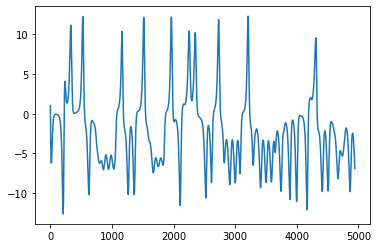

In [18]:
signal = point_cloud[:,0]
plt.plot(signal)
plt.show()

The resulting time series is much more complicated than our sine curve above. Let's see if the sliding window embedding reconstructs the Lorenz attractor (topologically).

**Full Disclosure:** The upper bound of 3 on the time delay in the next cell was chosen by playing with parameters for a while. So this reconstruction is not fully unsupervised...

In [19]:
embedding_dimension = 20
time_delay = 3
embedder = SingleTakensEmbedding(parameters_type='search', dimension=embedding_dimension, time_delay=time_delay)
embedded_signal = embedder.fit_transform(signal)

print('Optimal embedding time delay based on mutual information:', embedder.time_delay_)
print('Optimal embedding dimension based on false nearest neighbors:',embedder.dimension_)
print('Shape of embedded point cloud:', embedded_signal.shape)

Optimal embedding time delay based on mutual information: 3
Optimal embedding dimension based on false nearest neighbors: 16
Shape of embedded point cloud: (4897, 16)


Since we are embedding in high dimensions, we can't plot the full dimensional point cloud. We can project to a 3-dimensional subspace and plot the result. We'll use the first three principal vectors.

In [20]:
from sklearn.decomposition import PCA

In [21]:
pca = PCA(n_components=3)
X = pca.fit_transform(embedded_signal)
plot_point_cloud(X)

Computing the persistent homology of a point cloud with ~5k points takes a while. Let's subsample the point cloud before doing the computation, for the sake of class time.

In [22]:
subsample_factor = 5
subsampled_embedded_signal = np.array([embedded_signal[subsample_factor*t,:] for t in range(int(len(embedded_signal)/subsample_factor))])
print(len(subsampled_embedded_signal))

979


In [23]:
homology_dimensions = [1]
VR = VietorisRipsPersistence(
    metric='euclidean', max_edge_length=100, homology_dimensions=homology_dimensions)

X_diagrams = VR.fit_transform(subsampled_embedded_signal[None, :, :])

In [24]:
plot_diagram(X_diagrams[0])

## Gravitational Waves

Now let's use Takens embedding in a more realistic data analysis pipeline. This part of the notebook is adapted from an example provided in the `giotto-tda` documentation --- see [GitHub](https://github.com/giotto-ai/giotto-tda/blob/master/examples/gravitational_waves_detection.ipynb). They have plenty of other cool examples to try freely available on their GitHub, I highly recommend checking it out!

This experiment attepts to detect gravitational waves from noisy data using Takens embeddings. It is based on the article [Detection of gravitational waves using topological data analysis and convolutional neural network: An improved approach](https://arxiv.org/abs/1910.08245) by Christopher Bresten and Jae-Hun Jung.

In the article, the authors create a synthetic training set as follows: 

* Generate gravitational wave signals that correspond to non-spinning binary black hole mergers
* Generate a noisy time series and embed a gravitational wave signal with probability 0.5 at a random time.

The result is a set of time series of the form

$$ s = g + \epsilon \frac{1}{R}\xi $$

where $g$ is a gravitational wave signal from the reference set, $\xi$ is Gaussian noise, $\epsilon=10^{-19}$ scales the noise amplitude to the signal, and $R \in (0.075, 0.65)$ is a parameter that controls the signal-to-noise-ratio (SNR).

## Constant signal-to-noise ratio

As a warmup, let's generate some noisy signals with a constant SNR of 17.98. As shown in Table 1 of the article, this corresponds to an $R$ value of 0.65. We'll run the experiment on a small-ish dataset for the sake of finishing within class time.

In [25]:
from pathlib import Path

def make_gravitational_waves(
    path_to_data: Path,
    n_signals: int = 30,
    downsample_factor: int = 2,
    r_min: float = 0.075,
    r_max: float = 0.65,
    n_snr_values: int = 10,
        ):
    def padrand(V, n, kr):
        cut = np.random.randint(n)
        rand1 = np.random.randn(cut)
        rand2 = np.random.randn(n - cut)
        out = np.concatenate((rand1 * kr, V, rand2 * kr))
        return out

    Rcoef = np.linspace(r_min, r_max, n_snr_values)
    Npad = 500  # number of padding points on either side of the vector
    gw = np.load(path_to_data / "gravitational_wave_signals.npy")
    Norig = len(gw["data"][0])
    Ndat = len(gw["signal_present"])
    N = int(Norig / downsample_factor)

    ncoeff = []
    Rcoeflist = []

    for j in range(n_signals):
        ncoeff.append(10 ** (-19) * (1 / Rcoef[j % n_snr_values]))
        Rcoeflist.append(Rcoef[j % n_snr_values])

    noisy_signals = []
    gw_signals = []
    k = 0
    labels = np.zeros(n_signals)

    for j in range(n_signals):
        signal = gw["data"][j % Ndat][range(0, Norig, downsample_factor)]
        sigp = int((np.random.randn() < 0))
        noise = ncoeff[j] * np.random.randn(N)
        labels[j] = sigp
        if sigp == 1:
            rawsig = padrand(signal + noise, Npad, ncoeff[j])
            if k == 0:
                k = 1
        else:
            rawsig = padrand(noise, Npad, ncoeff[j])
        noisy_signals.append(rawsig.copy())
        gw_signals.append(signal)

    return noisy_signals, gw_signals, labels

In [26]:
R = 0.65
n_signals = 100
DATA = Path("./data")

noisy_signals, gw_signals, labels = make_gravitational_waves(
    path_to_data=DATA, n_signals=n_signals, r_min=R, r_max=R, n_snr_values=1
)

print(f"Number of noisy signals: {len(noisy_signals)}")
print(f"Number of timesteps per series: {len(noisy_signals[0])}")

Number of noisy signals: 100
Number of timesteps per series: 8692


The code below visualizes the data we are working with.

In [27]:
import numpy as np
from plotly.subplots import make_subplots
import plotly.graph_objects as go

# get the index corresponding to the first pure noise time series
background_idx = np.argmin(labels)
# get the index corresponding to the first noise + gravitational wave time series
signal_idx = np.argmax(labels)

ts_noise = noisy_signals[background_idx]
ts_background = noisy_signals[signal_idx]
ts_signal = gw_signals[signal_idx]

fig = make_subplots(rows=1, cols=2)

fig.add_trace(
    go.Scatter(x=list(range(len(ts_noise))), y=ts_noise, mode="lines", name="noise"),
    row=1,
    col=1,
)

fig.add_trace(
    go.Scatter(
        x=list(range(len(ts_background))),
        y=ts_background,
        mode="lines",
        name="background",
    ),
    row=1,
    col=2,
)

fig.add_trace(
    go.Scatter(x=list(range(len(ts_signal))), y=ts_signal, mode="lines", name="signal"),
    row=1,
    col=2,
)
fig.show()

Let's use the Takens embedding to turn each time series in our dataset into a point cloud. Note that there is an extra parameter here called 'stride'. This has the effect of subsampling the time series (by a factor of `stride`). This will be useful to improve computation time.

In [28]:
embedding_dimension = 30
embedding_time_delay = 30
stride = 5

embedder = SingleTakensEmbedding(
    parameters_type="search", n_jobs=6, time_delay=embedding_time_delay, dimension=embedding_dimension, stride=stride
)

y_gw_embedded = embedder.fit_transform(gw_signals[0])

As we did above, we can project to a 3-dimensional PCA basis to visualize the embedded data.

In [29]:
from sklearn.decomposition import PCA
from gtda.plotting import plot_point_cloud

pca = PCA(n_components=3)
y_gw_embedded_pca = pca.fit_transform(y_gw_embedded)

plot_point_cloud(y_gw_embedded_pca)

The code below visualizes an embedding of pure noise data.

In [30]:
embedding_dimension = 30
embedding_time_delay = 30
stride = 5

embedder = SingleTakensEmbedding(
    parameters_type="search", n_jobs=6, time_delay=embedding_time_delay, dimension=embedding_dimension, stride=stride
)

y_noise_embedded = embedder.fit_transform(noisy_signals[background_idx])

pca = PCA(n_components=3)
y_noise_embedded_pca = pca.fit_transform(y_noise_embedded)

plot_point_cloud(y_noise_embedded_pca)

### Define the topological feature generation pipeline

The code below creates a Takens embedding for each time series in our dataset, normalizes the embedded point clouds, computes degree-0 and degree-1 persistent homology and then collects some summary statistics---in particular, the [Persistence Entropy](https://arxiv.org/pdf/1902.06467.pdf). Each time series ends up being represented by a two-dimensional vector!

The hyperparameters below are taken from the original example on the `giotto` GitHub.

In [31]:
from gtda.diagrams import PersistenceEntropy, Scaler
from gtda.homology import VietorisRipsPersistence
from gtda.metaestimators import CollectionTransformer
from gtda.pipeline import Pipeline
from gtda.time_series import TakensEmbedding

embedding_dimension = 200
embedding_time_delay = 10
stride = 10

embedder = TakensEmbedding(time_delay=embedding_time_delay,
                           dimension=embedding_dimension,
                           stride=stride)

batch_pca = CollectionTransformer(PCA(n_components=3))

persistence = VietorisRipsPersistence(homology_dimensions=[0, 1])

scaling = Scaler()

entropy = PersistenceEntropy(normalize=True, nan_fill_value=-10)


steps = [("embedder", embedder),
         ("pca", batch_pca),
         ("persistence", persistence),
         ("scaling", scaling),
         ("entropy", entropy)]
topological_transfomer = Pipeline(steps)

In [32]:
features = topological_transfomer.fit_transform(noisy_signals)

### Train and evaluate a model

Now let's see how well our features can be classified via Support Vector Machines. See we have a small dataset, let's do a number of train/test splits. This can be accomplished via the `cross-validate` function.

In [33]:
from sklearn.model_selection import cross_validate

In [34]:
from sklearn.svm import SVC
modelSVM = SVC()

In [35]:
cv_results = cross_validate(modelSVM,features,labels,cv = 20)

In [36]:
np.mean(cv_results['test_score'])

0.7200000000000001

Not bad for such a simple model!

**Challenge:** Create a better model using some other vectorization scheme for persistence diagrams, different Takens Embedding parameters and/or a different classification model.